# Isotropic elastic wave equation implementation on a staggered grid

Some preamble here

In [1]:
import devito as dv

In [2]:
# Create a 3D grid
shape = (51, 51, 51)
extent = (500., 500., 500.)  # this is km

grid = dv.Grid(shape=shape, extent=extent)

# Vectorial form

One of the advantages of Devito is the high level symbolic API. This allows for straight forward generalisation of expressions between 2D and 3D. 


Leveraging the symbolic algebra capabilities of Devito enables concise, flexible specifications of equations. In this case, it's desirable to represent the isotropic elastic system of equations in the following form:


\begin{cases}
&\frac{dv}{dt} = \underline{\nabla} . \tau \\
&\frac{d \tau}{dt} = \lambda \text{diag}(\underline{\nabla} . \underline{v}) + \mu (\underline{\nabla} \underline{v} + (\underline{\nabla} \underline{v})^T)
\end{cases}


where in 3D, $\underline{v}$ is a vector valued function:

$\underline{v}(t, x, y, z) = (v_x(t, x, y, z), v_y(t, x, y, z), v_z(t, x, y, z))$

and the stress $\tau$ is a symmetric tensor valued function:


$\tau(t, x, y, z) = \begin{bmatrix}\tau_{xx}(t, x, y, z) & \tau_{xy}(t, x, y, z)  & \tau_{xz}(t, x, y, z) \\\tau_{yx}(t, x, y, z) & \tau_{yy}(t, x, y, z) & \tau_{yz}(t, x, y, z)  \\\tau_{zx}(t, x, y, z) & \tau_{zy}(t, x, y, z) & \tau_{zz}(t, x, y, z)\end{bmatrix}$


We show in the following how to setup the elastic wave-equation form Devito's high-level tensorial types.

As $\underline{v}$ is a vector which varies in time, we represent it as a `VectorTimeFunction`.

In [3]:
so = 4
to = 1

v = dv.VectorTimeFunction(name='v', grid=grid, space_order=so, time_order=to)
v

Vector(v_x(t, x + h_x/2, y, z), v_y(t, x, y + h_y/2, z), v_z(t, x, y, z + h_z/2))

We can see that staggering is applied by default.

There is also a `TensorTimeFunction` to store $\tau$:

In [4]:
τ = dv.TensorTimeFunction(name='tau', grid=grid, space_order=so, time_order=to)
τ

Matrix([
[                tau_xx(t, x, y, z), tau_xy(t, x + h_x/2, y + h_y/2, z), tau_xz(t, x + h_x/2, y, z + h_z/2)],
[tau_xy(t, x + h_x/2, y + h_y/2, z),                 tau_yy(t, x, y, z), tau_yz(t, x, y + h_y/2, z + h_z/2)],
[tau_xz(t, x + h_x/2, y, z + h_z/2), tau_yz(t, x, y + h_y/2, z + h_z/2),                 tau_zz(t, x, y, z)]])

Note that staggering is also applied here by default. Furthermore, this tensor is symmetrical:

In [5]:
τ[0, 1] is τ[1, 0]

True

Let's define our parameters. Whilst these will be constant for now, it is trivial to make them vary in space (as will be shown later). 

In [6]:
vs = 1500.  # s-wave velocity in km/s
vp = 2500.  # p-wave velocity in km/s
ρ = 3000.  # density in tons/m^3

b = 1/ρ
μ = vs**2/ρ
λ = (vp**2/ρ) - 2*μ

With this, we can write our equations in the following way:

Firstly, for the velocity equation: $\frac{dv}{dt} = \underline{\nabla} . \tau$, we formulate it as follows:

In [7]:
pde_v = v.dt - b * dv.div(τ)
pde_v

Vector(-0.000333333333333333*Derivative(tau_xx(t, x, y, z), x) - 0.000333333333333333*Derivative(tau_xy(t, x + h_x/2, y + h_y/2, z), y) - 0.000333333333333333*Derivative(tau_xz(t, x + h_x/2, y, z + h_z/2), z) + Derivative(v_x(t, x + h_x/2, y, z), t), -0.000333333333333333*Derivative(tau_xy(t, x + h_x/2, y + h_y/2, z), x) - 0.000333333333333333*Derivative(tau_yy(t, x, y, z), y) - 0.000333333333333333*Derivative(tau_yz(t, x, y + h_y/2, z + h_z/2), z) + Derivative(v_y(t, x, y + h_y/2, z), t), -0.000333333333333333*Derivative(tau_xz(t, x + h_x/2, y, z + h_z/2), x) - 0.000333333333333333*Derivative(tau_yz(t, x, y + h_y/2, z + h_z/2), y) - 0.000333333333333333*Derivative(tau_zz(t, x, y, z), z) + Derivative(v_z(t, x, y, z + h_z/2), t))

And for the stress equation: $\frac{d \tau}{dt} = \lambda \text{diag}(\underline{\nabla} . \underline{v}) + \mu (\underline{\nabla} \underline{v} + (\underline{\nabla} \underline{v})^T)$:

In [8]:
pde_tau = τ.dt - λ * dv.diag(dv.div(v.forward)) - μ * (dv.grad(v.forward) + dv.grad(v.forward).T)
# pde_tau  # uncomment to print (may go off of page)


In [9]:
# Time update 
u_v = dv.Eq(v.forward, dv.solve(pde_v, v.forward))
u_t = dv.Eq(τ.forward,  dv.solve(pde_tau, τ.forward))

We will need to create a source to inject into this field. For this we will import a `RickerSource` from the examples. Note that this is a thin wrapper around `SparseTimeFunction` with a prefilled time series.

In [10]:
from examples.seismic import TimeAxis, RickerSource

t0, tn = 0., 400.
dt = 0.2*min(grid.spacing)/vs  # Courant number is 0.5
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = RickerSource(name='src', grid=grid, f0=0.010, time_range=time_range)
src.coordinates.data[:] = 250.

# The source injection term
src_xx = src.inject(field=τ.forward[0, 0], expr=dt*src)
src_yy = src.inject(field=τ.forward[1, 1], expr=dt*src)
src_zz = src.inject(field=τ.forward[2, 2], expr=dt*src)

Now we create a Devito `Operator`. Note the order of arguments supplied to the operator - this corresponds to the order of these updates within the time loop.

In [11]:
op = dv.Operator([u_v, u_t] + src_xx + src_yy + src_zz)
op(dt=dt)

Operator `Kernel` ran in 1280.03 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=1279.1205250000203, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.7651399999957409, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

With this, the wavefield can be rendered to show its 3D structure. We will choose the x normal stress field for this visualisation.

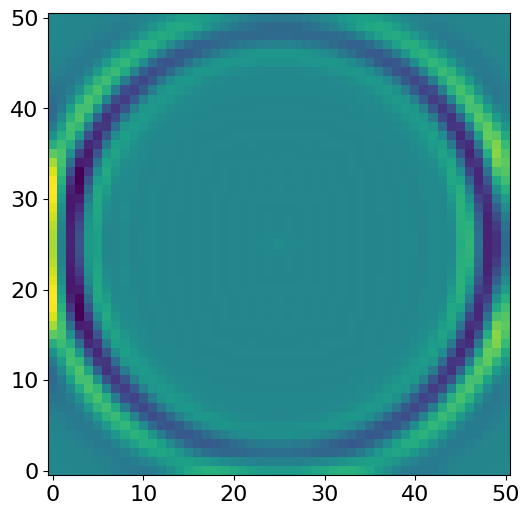

In [14]:
try:
    import pyvista as pv
except ModuleNotFoundError:
    ! pip install pyvista
    import pyvista as pv

rendergrid = pv.UniformGrid()
rendergrid.dimensions = np.array(τ.data[-1].shape) + 1
rendergrid.origin = (0., 0., 0.)
rendergrid.spacing = grid.spacing
rendergrid.cell_arrays["values"] = τ.data[-1].flatten(order="F")

y_slices = rendergrid.slice_along_axis(n=5, axis="y")
p = pv.Plotter(notebook=True, window_size=(600,400))
p.add_mesh(grid.outline(), color="k")
p.add_mesh(y_slices, cmap='seismic', opacity=0.8)
p.show()

In [15]:
import numpy as np
np.amax(τ[0, 0].data[-1, :, 25, :])

Data(0.04020383, dtype=float32)